In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
mydrive_path='/content/gdrive/MyDrive/Colab Notebooks/Sentiment_Prediction/'

In [3]:
#importing libraries
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
%matplotlib inline



from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report,roc_auc_score,confusion_matrix,f1_score,precision_score,accuracy_score
from sklearn.metrics import pairwise_distances
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb

In [4]:
pd.set_option('max_colwidth', 500)

In [5]:
# Reading the input from folder
master_df = pd.read_csv(mydrive_path + 'sample30.csv')
df=master_df.copy()
df.sample(5)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
2922,AVpe59io1cnluZ0-ZgDU,Universal Home Video,"Movies, Music & Books,Movies,Comedy,Movies & TV Shows,Instawatch Movies By VUDU,Shop Instawatch,Movies & TV,Ways To Shop Entertainment,Movies & Tv On Blu-Ray,Movies & Music,Instawatch,Blu-ray",Universal,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital),2016-07-22T00:00:00.000Z,NaN,True,5,Almost as funny as the first... Loved it just as much as the first one!,Great movie,NaN,NaN,sasysme33,Positive
27188,AVpfRoqcLJeJML436FqG,Vicks,"Personal Care,Medicine Cabinet,Cough/Cold,Health,Cough, Cold & Flu,Health & Beauty,Health Care,Over-the-Counter Medicine,Health & Household,Medications & Treatments,Cough & Cold,Chest Rubs,Health & Wellness,Allergy & Sinus",P&G,"Vicks Vaporub, Regular, 3.53oz",2015-03-28T00:00:00.000Z,False,True,5,vicks Rub is very effective during the cold and flu seasons and it can be used on both adults and children.,Vicks Vapor Rub,NaN,NaN,crewkey,Positive
13705,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen Cleaners,Cleaning Wipes,All-Purpose Cleaners,Health & Household,Household Supplies,Household Cleaning,Ways To Shop,Classroom Essentials,Featured Brands,Home And Storage & Org,Clorox,Glass Cleaners,Surface Care & Protection,Business & Industrial,Cleaning & Janitorial Supplies,Cleaners & Disinfectants,Cleaning Wipes & Pads,Cleaning Solutions,Housewares,Target Restock,Food & Grocery,Paper Goods,Wipes,All Purpose Cleaners",Clorox,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,2015-01-14T00:00:00.000Z,False,True,5,Been using these for Years on all our hard surfaces. always a good result. would recommend to anyone looking to kill germs in a flash This review was collected as part of a promotion.,momof3,NaN,NaN,momof31978,Positive
53,AV1h6Gu0glJLPUi8IjA_,Johnson's,"Personal Care,Baby Care,Baby Bubble Bath,Baby,Bath & Potty,Toiletries,Bubble Bath,Baby Bath,Bath & Body,Body Wash & Cleansers",Johnson's,"Johnson's Baby Bubble Bath and Wash, 15oz",2014-08-31T00:00:00.000Z,True,True,5,Really liked the fresh smell of this.,love,NaN,NaN,morgiana,Positive
15897,AVpf63aJLJeJML43F__Q,Burt's Bees,"Personal Care,Makeup,Lipstick, Lip Gloss, & Lip Balm,Lip Gloss,Beauty,Lips,Beauty & Personal Care,Skin Care,Lip Care,Lip Balms & Treatments",Burt's Bees,"Burt's Bees Lip Shimmer, Raisin",2012-11-24T00:00:00.000Z,False,True,4,"I recently have been to several stores looking for Bees cocoa. i rarely wear lip stick or anything on my lips. a couple yrs ago my sister got this for me and told me to try it, i was hooked, loved it. now i cant find it know where. then got on the computer, and found out its no longer available. omg please bring this back, its the only one i'll wear. thank you so much.",cocoa,NaN,NaN,crowder,Positive


In [6]:
### Total reviews
total = len(df['reviews_text'])
print ("Number of reviews: ",total)

### How many unique reviewers?
print ("Number of unique reviewers: ",len(df['reviews_username'].unique()))
reviewer_prop = float(len(df['reviews_username'].unique())/total)
print ("Prop of unique reviewers: ",round(reviewer_prop,3))

### Average star score
print ("Average rating score: ",round(df['reviews_rating'].mean(),3))

Number of reviews:  30000
Number of unique reviewers:  24915
Prop of unique reviewers:  0.831
Average rating score:  4.483


In [7]:
#data overivew
print('rows: ', df.shape[0])
print('columns: ', df.shape[1])
print('\nfeatures: ', df.columns.to_list())
print('\nmissing vlues: ', df.isnull().values.sum())
print('\nUnique values: \n', df.nunique())

rows:  30000
columns:  15

features:  ['id', 'brand', 'categories', 'manufacturer', 'name', 'reviews_date', 'reviews_didPurchase', 'reviews_doRecommend', 'reviews_rating', 'reviews_text', 'reviews_title', 'reviews_userCity', 'reviews_userProvince', 'reviews_username', 'user_sentiment']

missing vlues:  74980

Unique values: 
 id                        271
brand                     214
categories                270
manufacturer              227
name                      271
reviews_date             6857
reviews_didPurchase         2
reviews_doRecommend         2
reviews_rating              5
reviews_text            27282
reviews_title           18535
reviews_userCity          977
reviews_userProvince       42
reviews_username        24914
user_sentiment              2
dtype: int64


In [8]:
# Info of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

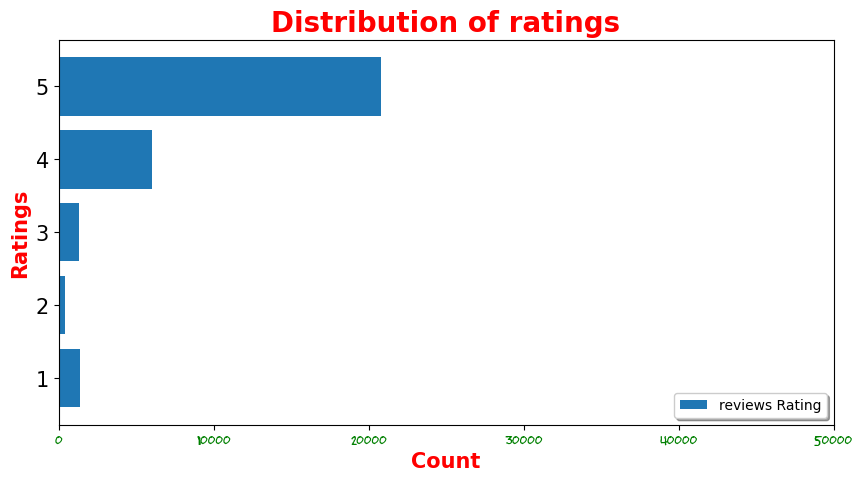

In [9]:
# Number of occurences for each rating
#plot ratings frequency
plt.figure(figsize=[10,5]) #[width, height]
x = list(df['reviews_rating'].value_counts().index)
y = list(df['reviews_rating'].value_counts())
plt.barh(x, y)
ticks_x = np.linspace(0, 50000, 6) # (start, end, no of ticks)
plt.xticks(ticks_x, fontsize=10, family='fantasy', color='Green')
plt.yticks(size=15)

plt.title('Distribution of ratings', fontsize=20, weight='bold', color='RED', loc='center')
plt.xlabel('Count', fontsize=15, weight='bold', color='RED')
plt.ylabel('Ratings', fontsize=15, weight='bold', color='RED')
plt.legend(['reviews Rating'], shadow=True, loc=4)

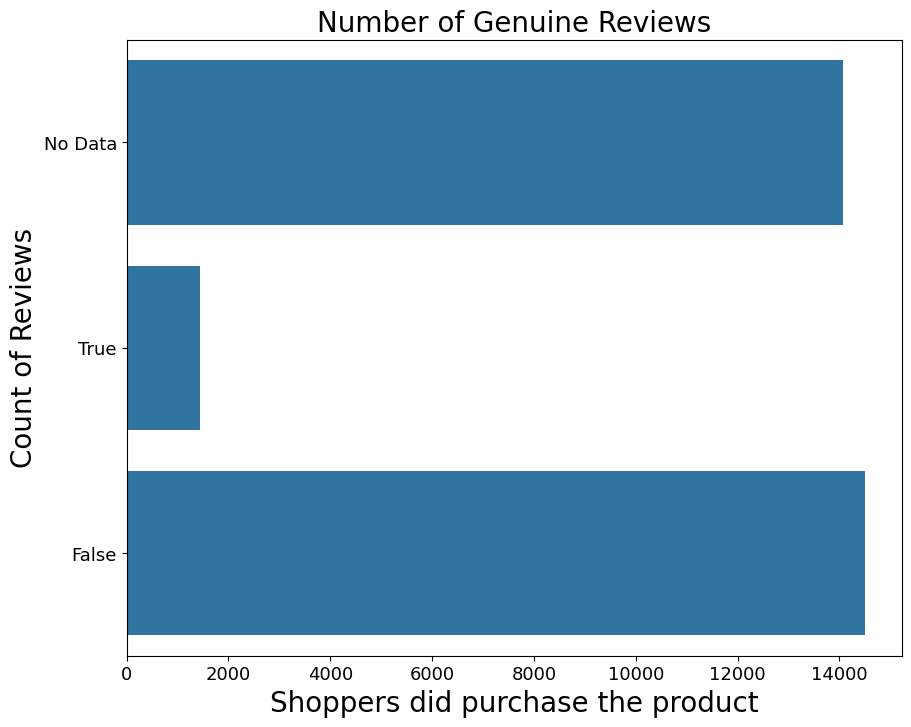

In [10]:
# Number of Postive and Negatives in the data frame showing the class imbalance
#Replace the Nan values to No Data for reviewers did purchase or not
df['reviews_didPurchase'].fillna('No Data', inplace=True)
#Distribution of reviews for actual purchasing customers
plt.figure(figsize=(10,8))
ax = sns.countplot(df['reviews_didPurchase'])
ax.set_xlabel(xlabel="Shoppers did purchase the product", fontsize=20)
ax.set_ylabel(ylabel='Count of Reviews', fontsize=20)
ax.axes.set_title('Number of Genuine Reviews', fontsize=20)
ax.tick_params(labelsize=13)

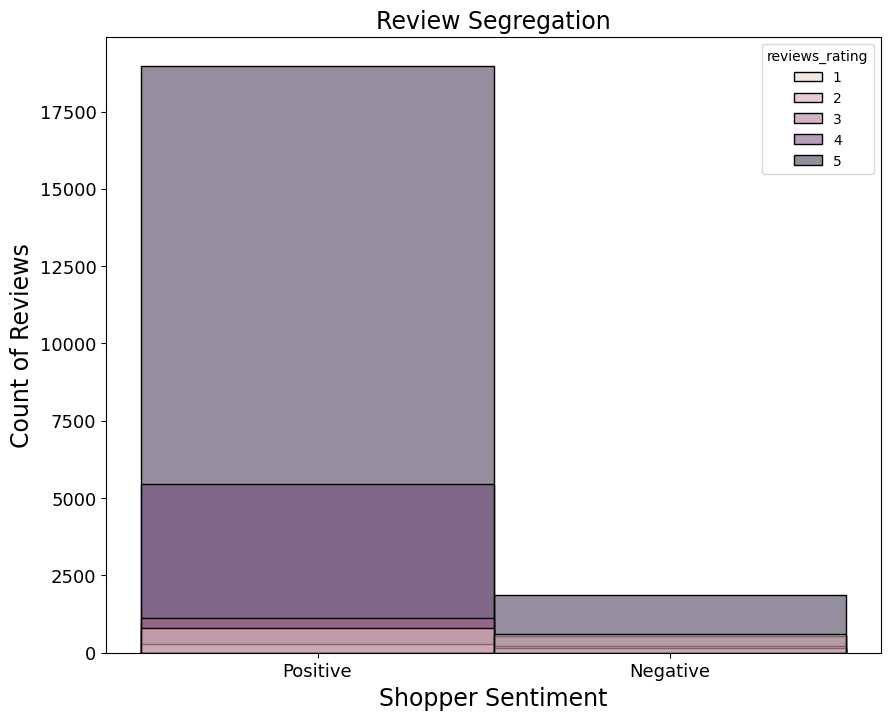

In [11]:
# To see any corrections are required in the dataframe is required using rating and user sentiment
# from IPython.core.pylabtools import figsize
# figsize(10,10)
# sns.histplot(hue=df['reviews_rating'],x=df['user_sentiment'])
# plt.yticks(np.arange(0,30000,10000))
# plt.show()

plt.figure(figsize=(10,8))
ax = sns.histplot(hue=df['reviews_rating'],x=df['user_sentiment'])
ax.set_xlabel(xlabel="Shopper Sentiment", fontsize=17)
ax.set_ylabel(ylabel='Count of Reviews', fontsize=17)
ax.axes.set_title('Review Segregation', fontsize=17)
ax.tick_params(labelsize=13)

In [12]:
df['user_sentiment'].value_counts()

Positive    26632
Negative     3367
Name: user_sentiment, dtype: int64

In [13]:
# To download the stopwords from NLTK library
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

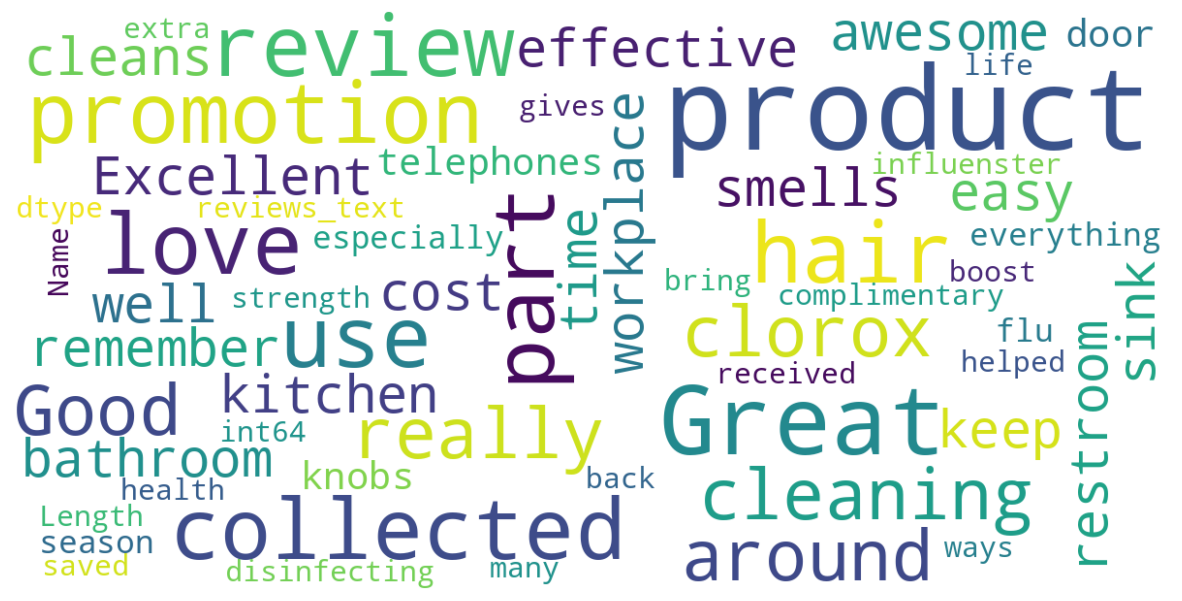

In [14]:
# To Check the most word occurence using word cloud
from wordcloud import WordCloud ,STOPWORDS
stopwords = set(STOPWORDS)
wordcloud = WordCloud(background_color='white', stopwords=stopwords, max_words=300, max_font_size=40,
                     scale=3, random_state=1).generate(str(df['reviews_text'].value_counts()))
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**2. Data Cleaning**





In [15]:
# Finding the number of rows with Null values
df.isnull().sum()

id                          0
brand                       0
categories                  0
manufacturer              141
name                        0
reviews_date               46
reviews_didPurchase         0
reviews_doRecommend      2570
reviews_rating              0
reviews_text                0
reviews_title             190
reviews_userCity        28071
reviews_userProvince    29830
reviews_username           63
user_sentiment              1
dtype: int64

In [16]:
#shape of the dataframe
df.shape

(30000, 15)

In [17]:
#From the null values percentages, columns reviews_userCity and reviews_userProvince can be dropped
df = df.drop(columns=['reviews_userCity','reviews_userProvince'],axis=1)
df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,No Data,NaN,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part of a promotion.,Good,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensatio...",Disappointed,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation,walker557,Negative


In [18]:
# Finding the number of rows with Null values
print("shape of the dataframe =",df.shape)
df.isnull().sum()/len(df)

shape of the dataframe = (30000, 13)


id                     0.000000
brand                  0.000000
categories             0.000000
manufacturer           0.004700
name                   0.000000
reviews_date           0.001533
reviews_didPurchase    0.000000
reviews_doRecommend    0.085667
reviews_rating         0.000000
reviews_text           0.000000
reviews_title          0.006333
reviews_username       0.002100
user_sentiment         0.000033
dtype: float64

In [19]:
# Before Updating the user sentiment columns
df['user_sentiment'].value_counts()

Positive    26632
Negative     3367
Name: user_sentiment, dtype: int64

In [20]:
# for correcting the user sentiment according to rating
def review_sentiment_clear(x):
  if x >= 3 :
    return 'Postive'
  elif x > 0 and x < 3  :
    return 'Negative'

In [21]:
df['user_sentiment'] = df['reviews_rating'].apply(review_sentiment_clear)
df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,No Data,NaN,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,joshua,Postive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part of a promotion.,Good,dorothy w,Postive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,dorothy w,Postive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensatio...",Disappointed,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation,walker557,Negative


In [22]:
# After corrections for user sentiment
df['user_sentiment'].value_counts()

Postive     28196
Negative     1804
Name: user_sentiment, dtype: int64

**3. Text Preprocessing**

**Text lower cased , removed Special Charater and lemmatized**

In [23]:
#Common functions for cleaning the text data
import nltk
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
import unicodedata
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import re
import html

# special_characters removal
def remove_special_characters(text, remove_digits=True):
    """Remove the special Characters"""
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation_and_splchars(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_word = remove_special_characters(new_word, True)
            new_words.append(new_word)
    return new_words

stopword_list= stopwords.words('english')

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopword_list:
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = to_lowercase(words)
    words = remove_punctuation_and_splchars(words)
    words = remove_stopwords(words)
    return words

def lemmatize(words):
    lemmas = lemmatize_verbs(words)
    return lemmas

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [24]:
def normalize_and_lemmaize(input_text):
    input_text = remove_special_characters(input_text)
    words = nltk.word_tokenize(input_text)
    words = normalize(words)
    lemmas = lemmatize(words)
    return ' '.join(lemmas)

In [25]:
# Take the Review comment and user sentiment as dataframe
review_df = df[['reviews_text','user_sentiment']]
review_df.head()

,reviews_text,user_sentiment
0,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Postive
1,Good flavor. This review was collected as part of a promotion.,Postive
2,Good flavor.,Postive
3,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensatio...",Negative
4,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Negative


In [26]:
# create a new column lemmatized_review using the emmatize_text function
review_df['lemmatized_text'] = review_df['reviews_text'].map(lambda text: normalize_and_lemmaize(text))
review_df.head()

<ipython-input-26-44c2cf38853f>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,reviews_text,user_sentiment,lemmatized_text
0,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Postive,love album good hip hop side current pop sound hype listen everyday gym give star rat way metaphors crazy
1,Good flavor. This review was collected as part of a promotion.,Postive,good flavor review collect part promotion
2,Good flavor.,Postive,good flavor
3,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensatio...",Negative,read review look buy one couple lubricants ultimately disappoint didnt even live review read starters neither boyfriend could notice sort enhance captivate sensation notice however messy consistency reminiscent liquidy vaseline difficult clean pleasant especially since lack captivate sensation expect im disappoint pay much lube wont use could use normal personal lubricant less money less mess
4,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Negative,husband buy gel us gel cause irritation felt like burn skin wouldnt recommend gel


In [27]:
# new dataframe with lemmatized text and user sentiment
review_new_df = review_df[['lemmatized_text','user_sentiment']]
review_new_df

,lemmatized_text,user_sentiment
0,love album good hip hop side current pop sound hype listen everyday gym give star rat way metaphors crazy,Postive
1,good flavor review collect part promotion,Postive
2,good flavor,Postive
3,read review look buy one couple lubricants ultimately disappoint didnt even live review read starters neither boyfriend could notice sort enhance captivate sensation notice however messy consistency reminiscent liquidy vaseline difficult clean pleasant especially since lack captivate sensation expect im disappoint pay much lube wont use could use normal personal lubricant less money less mess,Negative
4,husband buy gel us gel cause irritation felt like burn skin wouldnt recommend gel,Negative
...,...,...
29995,get conditioner influenster try im love far oily hair use end hair feel amaze soft mess review collect part promotion,Postive
29996,love receive review purpose influenster leave hair feel fresh smell great,Postive
29997,first love smell product wash hair smooth easy brush receive product influenster test purpose opinions review collect part promotion,Postive
29998,receive influenster never go back anything else normally dont use conditioner hair oily fine make hair feel heavy doesnt get oily day really fantastic plan buy future review collect part promotion,Postive


In [28]:
#Encode the negative and postive to 0 and 1 respectively
review_new_df['user_sentiment'] = review_new_df['user_sentiment'].map({'Negative':0,'Postive':1})
review_new_df.head()

<ipython-input-28-6d6bf15b2db6>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,lemmatized_text,user_sentiment
0,love album good hip hop side current pop sound hype listen everyday gym give star rat way metaphors crazy,1
1,good flavor review collect part promotion,1
2,good flavor,1
3,read review look buy one couple lubricants ultimately disappoint didnt even live review read starters neither boyfriend could notice sort enhance captivate sensation notice however messy consistency reminiscent liquidy vaseline difficult clean pleasant especially since lack captivate sensation expect im disappoint pay much lube wont use could use normal personal lubricant less money less mess,0
4,husband buy gel us gel cause irritation felt like burn skin wouldnt recommend gel,0


**Dividing the dataset into train and test data and handle the class imbalance**

In [29]:
!pip install pandas scikit-learn

In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [31]:
from collections import Counter
from imblearn.over_sampling import SMOTE

In [32]:
# Train and Test Divide
x_train,x_test,y_train,y_test = train_test_split(review_new_df['lemmatized_text'],review_new_df['user_sentiment'],train_size=0.75,random_state=45,stratify=review_new_df['user_sentiment'])


In [33]:
y_train.value_counts()

1    21147
0     1353
Name: user_sentiment, dtype: int64

4. Feature Extraction using Count Vectorizer and TFIDF Transformer

In [34]:
from sklearn.feature_extraction.text import TfidfTransformer
count_vect = CountVectorizer()
x_count = count_vect.fit_transform(x_train)


tfidf_transformer = TfidfTransformer()
x_train_transformed = tfidf_transformer.fit_transform(x_count)
x_train_transformed.shape

(22500, 14711)

In [35]:
#creating the pickle for countvectorizer and TFIDF Transformer
import pickle
pickle.dump(count_vect,open(mydrive_path+'pickle_file/count_vector.pkl','wb'))
pickle.dump(tfidf_transformer,open(mydrive_path+'pickle_file/tfidf_transformer.pkl','wb'))

In [36]:
count = Counter(y_train)
print('Before sampling :',count)

sampler = SMOTE()

x_train_sm,y_train_sm = sampler.fit_resample(x_train_transformed,y_train)

count = Counter(y_train_sm)
print('After sampling :',count)

Before sampling : Counter({1: 21147, 0: 1353})
After sampling : Counter({1: 21147, 0: 21147})


#5. **Training text classification model**
 - Logistic Regression
 - Random Forest Classifer
 - XGBoost
Choose the best model with hyperparameter tuning

#### Choose the best model with hyperparameter tuning

In [37]:
# Function for Metrics
performance=[]

def model_metrics(y,y_pred,model_name,metrics):
  Accuracy = accuracy_score(y,y_pred)
  roc = roc_auc_score(y,y_pred)
  confusion = confusion_matrix(y,y_pred)
  precision = precision_score(y,y_pred)
  f1 = f1_score(y,y_pred)
  TP = confusion[1,1]  # true positive
  TN = confusion[0,0]  # true negatives
  FP = confusion[0,1]  # false positives
  FN = confusion[1,0]  # false negatives
  sensitivity= TP / float(TP+FN)
  specificity = TN / float(TN+FP)

  print("*"*50)
  print('Confusion Matrix =')
  print(confusion)
  print("sensitivity of the %s = %f" % (model_name,round(sensitivity,2)))
  print("specificity of the %s = %f" % (model_name,round(specificity,2)))
  print("Accuracy Score of %s = %f" % (model_name,Accuracy))
  print('ROC AUC score of %s = %f' % (model_name,roc))
  print("Report=",)
  print(classification_report(y,y_pred))
  print("*"*50)
  metrics.append(dict({'Model_name':model_name,
                       'Accuracy':Accuracy,
                       'Roc_auc_score':roc,
                       'Precision':precision,
                       'F1_score':f1}))
  return metrics

#**Logistic** Regression

In [38]:
# 1. Logsitic Regression
lr = LogisticRegression()
lr.fit(x_train_sm,y_train_sm)

LogisticRegression()

In [39]:
y_pred = lr.predict(x_train_sm)
peformance = model_metrics(y_train_sm,y_pred,'Logistic Regression',performance)

**************************************************
Confusion Matrix =
[[20802   345]
 [  612 20535]]
sensitivity of the Logistic Regression = 0.970000
specificity of the Logistic Regression = 0.980000
Accuracy Score of Logistic Regression = 0.977373
ROC AUC score of Logistic Regression = 0.977373
Report=
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     21147
           1       0.98      0.97      0.98     21147

    accuracy                           0.98     42294
   macro avg       0.98      0.98      0.98     42294
weighted avg       0.98      0.98      0.98     42294

**************************************************


#**RandomForest** Classifier

In [40]:
# 2. RandomForest Classifier
rf = RandomForestClassifier()
rf.fit(x_train_sm,y_train_sm)

RandomForestClassifier()

In [41]:
y_pred_rf = rf.predict(x_train_sm)
performance = model_metrics(y_train_sm,y_pred_rf,'RandomForestClassifier',performance)

**************************************************
Confusion Matrix =
[[21145     2]
 [    1 21146]]
sensitivity of the RandomForestClassifier = 1.000000
specificity of the RandomForestClassifier = 1.000000
Accuracy Score of RandomForestClassifier = 0.999929
ROC AUC score of RandomForestClassifier = 0.999929
Report=
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21147
           1       1.00      1.00      1.00     21147

    accuracy                           1.00     42294
   macro avg       1.00      1.00      1.00     42294
weighted avg       1.00      1.00      1.00     42294

**************************************************


#**AdaBoost** Classifier

In [42]:
xgba = GradientBoostingClassifier()
xgba.fit(x_train_sm,y_train_sm)
y_pred_xgb = xgba.predict(x_train_sm)
peformance = model_metrics(y_train_sm,y_pred_rf,'AdaBoostclassifier',peformance)


**************************************************
Confusion Matrix =
[[21145     2]
 [    1 21146]]
sensitivity of the AdaBoostclassifier = 1.000000
specificity of the AdaBoostclassifier = 1.000000
Accuracy Score of AdaBoostclassifier = 0.999929
ROC AUC score of AdaBoostclassifier = 0.999929
Report=
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21147
           1       1.00      1.00      1.00     21147

    accuracy                           1.00     42294
   macro avg       1.00      1.00      1.00     42294
weighted avg       1.00      1.00      1.00     42294

**************************************************


#**XGBoost**

In [43]:
  import xgboost as xgb

In [44]:
#XGBoostClassifier
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(x_train_sm,y_train_sm)
y_pred_xgbc = xgb_classifier.predict(x_train_sm)
peformance = model_metrics(y_train_sm,y_pred_xgbc,'XGBClassifier',peformance)


**************************************************
Confusion Matrix =
[[20826   321]
 [  126 21021]]
sensitivity of the XGBClassifier = 0.990000
specificity of the XGBClassifier = 0.980000
Accuracy Score of XGBClassifier = 0.989431
ROC AUC score of XGBClassifier = 0.989431
Report=
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     21147
           1       0.98      0.99      0.99     21147

    accuracy                           0.99     42294
   macro avg       0.99      0.99      0.99     42294
weighted avg       0.99      0.99      0.99     42294

**************************************************


In [45]:
metrics_df = pd.DataFrame(performance)
metrics_df

,Model_name,Accuracy,Roc_auc_score,Precision,F1_score
0,Logistic Regression,0.977373,0.977373,0.983477,0.977229
1,RandomForestClassifier,0.999929,0.999929,0.999905,0.999929
2,AdaBoostclassifier,0.999929,0.999929,0.999905,0.999929
3,XGBClassifier,0.989431,0.989431,0.984959,0.989480


# Hyperparameter Tuning of models

In [46]:
n_estimators = [200,400,600]
max_depth = [6,10,15]
min_samples_leaf = [5,6,8]
criterion  = ['gini','entropy']
params = {'n_estimators':n_estimators,
          'max_depth':max_depth,
          'min_samples_leaf': min_samples_leaf,
          'criterion':criterion}

In [47]:
grid_cv = GridSearchCV(estimator=rf,
                       param_grid=params,
                       n_jobs = -1,
                       scoring = 'roc_auc',
                       verbose = 1)

In [48]:
grid_cv.fit(x_train_sm,y_train_sm)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [6, 10, 15],
                         'min_samples_leaf': [5, 6, 8],
                         'n_estimators': [200, 400, 600]},
             scoring='roc_auc', verbose=1)

In [49]:
rf_final=grid_cv.best_estimator_
rf_final

RandomForestClassifier(max_depth=15, min_samples_leaf=5, n_estimators=600)

In [50]:
pickle.dump(rf_final,open(mydrive_path+'pickle_file/RandomForest_classifier.pkl','wb'))

In [51]:
grid_cv.best_score_

0.9776425854785181

In [52]:
y_pred_rfgcv = rf_final.predict(x_train_sm)
performance = model_metrics(y_train_sm,y_pred_rfgcv,'RandomForestClassifier with hyperparmater',performance)

**************************************************
Confusion Matrix =
[[17970  3177]
 [  633 20514]]
sensitivity of the RandomForestClassifier with hyperparmater = 0.970000
specificity of the RandomForestClassifier with hyperparmater = 0.850000
Accuracy Score of RandomForestClassifier with hyperparmater = 0.909916
ROC AUC score of RandomForestClassifier with hyperparmater = 0.909916
Report=
              precision    recall  f1-score   support

           0       0.97      0.85      0.90     21147
           1       0.87      0.97      0.92     21147

    accuracy                           0.91     42294
   macro avg       0.92      0.91      0.91     42294
weighted avg       0.92      0.91      0.91     42294

**************************************************


In [53]:
n_estimators = [200,400,600]
params_1 = {'n_estimators':n_estimators}

In [54]:
grid_cv_boost = GridSearchCV(estimator=xgba,
                       param_grid=params_1,
                       n_jobs = -1,
                       scoring = 'roc_auc',
                       verbose = 1)

In [55]:
grid_cv_boost.fit(x_train_sm,y_train_sm)


Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'n_estimators': [200, 400, 600]}, scoring='roc_auc',
             verbose=1)

In [ ]:
print('Best score for GradientBoosting=',grid_cv_boost.best_score_)

In [ ]:
xgb_final=grid_cv_boost.best_estimator_
xgb_final

In [ ]:
y_pred_xgbgcv = xgb_final.predict(x_train_sm)
peformance = model_metrics(y_train_sm,y_pred_xgbgcv,'GradientBoostClassifier with n = 600',peformance)

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
max_depth = [5,6,7,10]

params_2 = {'max_depth':max_depth}
grid_cv_boost2 = GridSearchCV(estimator=xgb_final,
                       param_grid=params_2,
                       n_jobs = -1,
                       scoring = 'roc_auc',
                       verbose = 1)

In [ ]:
grid_cv_boost2.fit(x_train_sm,y_train_sm)
print('Best score for GradientBoosting=',grid_cv_boost2.best_score_)
grid_cv_boost2.best_estimator_

In [ ]:
min_samples_split = [10,20,30]
params_2 = {'min_samples_split': min_samples_split
}
grid_cv_boost3 = GridSearchCV(estimator=grid_cv_boost2.best_estimator_,
                       param_grid=params_2,
                       n_jobs = -1,
                       scoring = 'roc_auc',
                       verbose = 1)

grid_cv_boost3.fit(x_train_sm,y_train_sm)
print('Best score for GradientBoosting=',grid_cv_boost3.best_score_)
grid_cv_boost3.best_estimator_

In [63]:
y_pred_xgbgcv2 = grid_cv_boost3.best_estimator_.predict(x_train_sm)
peformance = model_metrics(y_train_sm,y_pred_xgbgcv2,'GradientBoostClassifier with param2',peformance)
performance

**************************************************
Confusion Matrix =
[[21138     9]
 [    0 21147]]
sensitivity of the GradientBoostClassifier with param2 = 1.000000
specificity of the GradientBoostClassifier with param2 = 1.000000
Accuracy Score of GradientBoostClassifier with param2 = 0.999787
ROC AUC score of GradientBoostClassifier with param2 = 0.999787
Report=
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21147
           1       1.00      1.00      1.00     21147

    accuracy                           1.00     42294
   macro avg       1.00      1.00      1.00     42294
weighted avg       1.00      1.00      1.00     42294

**************************************************


[{'Model_name': 'Logistic Regression',
  'Accuracy': 0.9773726769754575,
  'Roc_auc_score': 0.9773726769754575,
  'Precision': 0.9834770114942529,
  'F1_score': 0.9772289242629737},
 {'Model_name': 'RandomForestClassifier',
  'Accuracy': 0.9999290679529012,
  'Roc_auc_score': 0.9999290679529012,
  'Precision': 0.9999054284093059,
  'F1_score': 0.9999290696299798},
 {'Model_name': 'AdaBoostclassifier',
  'Accuracy': 0.9999290679529012,
  'Roc_auc_score': 0.9999290679529012,
  'Precision': 0.9999054284093059,
  'F1_score': 0.9999290696299798},
 {'Model_name': 'XGBClassifier',
  'Accuracy': 0.989431124982267,
  'Roc_auc_score': 0.9894311249822668,
  'Precision': 0.9849592353106551,
  'F1_score': 0.989479630021888},
 {'Model_name': 'RandomForestClassifier with hyperparmater',
  'Accuracy': 0.9099163001844234,
  'Roc_auc_score': 0.9099163001844234,
  'Precision': 0.8658984424464987,
  'F1_score': 0.9150274320888533},
 {'Model_name': 'GradientBoostClassifier with n = 600',
  'Accuracy': 0.98

In [ ]:
metrics_df = pd.DataFrame(performance)
metrics_df

In [ ]:
rf_final = pickle.load(open(mydrive_path+'pickle_file/RandomForest_classifier.pkl','rb'))

In [ ]:
# After doing multiple tuning we get the below model and will be used in the sentiment based analysis
final_model = GradientBoostingClassifier(max_depth=10, min_samples_split=20, n_estimators=600)

In [ ]:
final_model.fit(x_train_sm,y_train_sm)

In [ ]:
pickle.dump(final_model,open(mydrive_path+'pickle_file/final_model.pkl','wb'))

In [ ]:
#Evaluatopn between lr , rf and boost
test_performance=[]
test_word_vect = count_vect.transform(x_test)
test_tfidf_vect = tfidf_transformer.transform(test_word_vect)

y_test_pred_lr = lr.predict(test_tfidf_vect)
test_peformance = model_metrics(y_test,y_test_pred_lr,'Logistic Regression',test_performance)

y_test_pred_xgbc = xgb_classifier.predict(test_tfidf_vect)
test_peformance = model_metrics(y_test,y_test_pred_xgbc,'XGBoost Classifier',test_performance)

y_test_pred_rf = rf_final.predict(test_tfidf_vect)
test_peformance = model_metrics(y_test,y_test_pred_rf,'Tuned RandomForestClassifier',test_performance)

y_test_pred_xgb = final_model.predict(test_tfidf_vect)
test_peformance = model_metrics(y_test,y_test_pred_xgb,'Tuned GradientBoostClassifier',test_performance)

test_metrics_df = pd.DataFrame(test_performance)
test_metrics_df

### Evaluation with test data after comparing
- Considering roc_auc_score ,performance.
- Logistic Regression is having more score and have good accuracy

In [ ]:
import pickle

In [71]:
#pickle.dump(lr,open(mydrive_path+'pickle_file/model.pkl','wb'))


In [ ]:
#rf_final = pickle.load(open(mydrive_path+'pickle_file/RandomForest_classifier.pkl','rb'))

#pickle.dump(final_model,open(mydrive_path+'pickle_file/final_model.pkl','wb'))

# 5. Recommedation system
- User and User recommedation system
- Item and Item recommedation system

In [ ]:
df = pd.read_csv(mydrive_path+'sample30.csv')
df.sample(5)

In [ ]:
len(df['name'].unique())

In [ ]:
from sklearn.model_selection import train_test_split
train,test = train_test_split(df,train_size=0.70,random_state=45)
print('train shape = ',train.shape)
print('test shape = ',test.shape)

In [ ]:
#using train dataset and create correlation matrix
train_pivot = pd.pivot_table(index='reviews_username',
                            columns='name',
                            values='reviews_rating',data=train).fillna(1)
train_pivot

In [77]:
#Creating the train and test dataset for predicting and evaluating the correlation
#fill 1 in place of Nan for prediction
train_pivot1 = pd.pivot_table(index='reviews_username',
                            columns='name',
                            values='reviews_rating',data=train).fillna(1)

In [78]:
train_pivot1.loc['piggyboy420']

name
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest           1.0
100:Complete First Season (blu-Ray)                                     1.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black       1.0
2x Ultra Era with Oxi Booster, 50fl oz                                  1.0
42 Dual Drop Leaf Table with 2 Madrid Chairs"                           1.0
                                                                       ... 
WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black    1.0
Weleda Everon Lip Balm                                                  1.0
Windex Original Glass Cleaner Refill 67.6oz (2 Liter)                   1.0
Yes To Carrots Nourishing Body Wash                                     1.0
Yes To Grapefruit Rejuvenating Body Wash                                1.0
Name: piggyboy420, Length: 254, dtype: float64

In [79]:
import numpy as np

def cosine_similarity(df):
    # using the adjusted cosine similarity
    mean_df = np.nanmean(df,axis=1)
    substracted_df = (df.T - mean_df).T # Normalized dataset
    # using the pairwise_distance for cosine similarity
    user_correlation = 1- pairwise_distances (substracted_df.fillna(0),metric='cosine')
    user_correlation[np.isnan(user_correlation)] = 0
    return user_correlation,substracted_df


In [80]:
user_corr_matrix,normalized_df = cosine_similarity(train_pivot1)
user_corr_matrix

array([[ 1.        , -0.00395257, -0.00395257, ..., -0.00395257,
        -0.00395257,  1.        ],
       [-0.00395257,  1.        ,  1.        , ..., -0.00395257,
        -0.00395257, -0.00395257],
       [-0.00395257,  1.        ,  1.        , ..., -0.00395257,
        -0.00395257, -0.00395257],
       ...,
       [-0.00395257, -0.00395257, -0.00395257, ...,  1.        ,
         1.        , -0.00395257],
       [-0.00395257, -0.00395257, -0.00395257, ...,  1.        ,
         1.        , -0.00395257],
       [ 1.        , -0.00395257, -0.00395257, ..., -0.00395257,
        -0.00395257,  1.        ]])

In [81]:
user_corr_matrix.shape

(18205, 18205)

In [82]:
user_corr_matrix[user_corr_matrix < 0] = 0
user_corr_matrix.shape

(18205, 18205)

In [83]:
df[df['reviews_username'] == 'zzz1127']

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
7256,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen Cleaners,Cleaning Wipes,All-Purpose Cleaners,Health & Household,Household Supplies,Household Cleaning,Ways To Shop,Classroom Essentials,Featured Brands,Home And Storage & Org,Clorox,Glass Cleaners,Surface Care & Protection,Business & Industrial,Cleaning & Janitorial Supplies,Cleaners & Disinfectants,Cleaning Wipes & Pads,Cleaning Solutions,Housewares,Target Restock,Food & Grocery,Paper Goods,Wipes,All Purpose Cleaners",Clorox,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,2014-12-03T00:00:00.000Z,False,True,4,These wipes are very handy for getting your cleaning done quickly. I keep them in the bathroom and use them to wipe down all surface areas for a quick 10 minute cleaning. Keep it up every week and it's that easy to maintain a clean room. This review was collected as part of a promotion.,Handy Wipes for Quick Cleaning,NaN,NaN,zzz1127,Positive


In [84]:
user_pred_ratings = np.dot(user_corr_matrix,train_pivot1.fillna(0))
user_pred_ratings

array([[ 437.75576386,  438.26995035,  437.75576386, ...,  443.40142748,
         440.05601875,  437.75576386],
       [2120.11694472, 2138.77377911, 2120.11694472, ..., 2132.78849166,
        2120.11694472, 2121.98528539],
       [2120.11694472, 2138.77377911, 2120.11694472, ..., 2132.78849166,
        2120.11694472, 2121.98528539],
       ...,
       [5461.34652523, 5465.56431548, 5461.34652523, ..., 5467.89333212,
        5464.16935704, 5461.34652523],
       [5461.34652523, 5465.56431548, 5461.34652523, ..., 5467.89333212,
        5464.16935704, 5461.34652523],
       [ 437.75576386,  438.26995035,  437.75576386, ...,  443.40142748,
         440.05601875,  437.75576386]])

In [ ]:
user_pred_ratings.shape

In [ ]:
user_final_rating = np.multiply(user_pred_ratings,train_pivot)
user_final_rating

In [87]:
# Creating a pickle file for user-user recommendation system
import pickle
pickle.dump(user_final_rating,open(mydrive_path+'pickle_file/user_final_rating.pkl','wb'))

In [88]:
d = user_final_rating
d.loc['piggyboy420'].sort_values(ascending=False)[:20]

name
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest                          0.0
Pleasant Hearth 7.5 Steel Grate, 30 5 Bar - Black                                      0.0
Olivella Bar Soap - 3.52 Oz                                                            0.0
Orajel Maximum Strength Toothache Pain Relief Liquid                                   0.0
Pantene Color Preserve Volume Shampoo, 25.4oz                                          0.0
Pantene Pro-V Expert Collection Age Defy Conditioner                                   0.0
Pearhead Id Bracelet Frame                                                             0.0
Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack        0.0
Physicians Formula Mineral Wear Talc-Free Mineral Correcting Powder, Creamy Natural    0.0
Physicians Formula Powder Palette Mineral Glow Pearls, Translucent Pearl               0.0
Pinaud Clubman Styling Gel, Superhold                                                

### Evaluation for user-user recommendation system

In [89]:
## Evaluation
common = test[test.reviews_username.isin(train.reviews_username)]
common.shape

(2006, 15)

In [90]:
corr_df = pd.DataFrame(user_corr_matrix)

In [91]:
corr_df

,0,1,2,3,4,5,6,7,8,9,...,18195,18196,18197,18198,18199,18200,18201,18202,18203,18204
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
4,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
18201,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
18202,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
18203,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0


In [92]:
corr_df['user_name'] = normalized_df.index
corr_df.set_index('user_name',inplace=True)
corr_df

,0,1,2,3,4,5,6,7,8,9,...,18195,18196,18197,18198,18199,18200,18201,18202,18203,18204
user_name,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
02dakota,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
06stidriver,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zuttle,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
zwithanx,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
zxcsdfd,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0


In [93]:
list_name = common.reviews_username.tolist()

In [94]:
corr_df.columns = normalized_df.index.tolist()
corr_df.columns

Index(['00sab00', '02dakota', '02deuce', '0325home', '06stidriver', '1.11E+24',
       '1085', '10ten', '11111111aaaaaaaaaaaaaaaaa', '11677j',
       ...
       'zowie', 'zozo0o', 'zsazsa', 'zt313', 'zubb', 'zuttle', 'zwithanx',
       'zxcsdfd', 'zyiah4', 'zzdiane'],
      dtype='object', length=18205)

In [95]:
corr_df1 = corr_df[corr_df.index.isin(list_name)]
corr_df1.shape

(1687, 18205)

In [96]:
corr_df2 = corr_df1.T[corr_df1.T.index.isin(list_name)]
corr_df3 = corr_df2.T
corr_df3.head()

,1234,123charlie,143st,1943,4cloroxl,50cal,7inthenest,aac06002,aaron,abby,...,yeya,ygtz,yohnie1,yshan,yucky111,yummy,yvonne,zburt5,zebras,zippy
user_name,,,,,,,,,,,,,,,,,,,,,
1234,1.000000,0.684558,0.0,0.223114,0.0,0.511718,0.0,0.0,0.837534,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.278697
123charlie,0.684558,1.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.656818,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
143st,0.000000,0.000000,1.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1943,0.223114,0.000000,0.0,1.000000,0.0,0.444381,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.242522
4cloroxl,0.000000,0.000000,0.0,0.000000,1.0,0.000000,1.0,0.0,0.000000,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000


In [97]:
common_user_tb = pd.pivot_table(index='reviews_username',
                            columns='name',
                            values='reviews_rating',data=common)

In [98]:
common_user_tb

name,100:Complete First Season (blu-Ray),Alex Cross (dvdvideo),"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,...,Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123charlie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143st,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1943,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4cloroxl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yummy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
yvonne,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zburt5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [99]:
corr_df3[corr_df3<0] = 0
common_user_rating =  np.dot(corr_df3,common_user_tb.fillna(0))
common_user_rating

array([[7.4987797 , 1.20864234, 0.        , ..., 7.64092148, 0.92858292,
        0.        ],
       [1.74826633, 0.        , 0.        , ..., 3.36140237, 0.        ,
        0.        ],
       [5.67106405, 5.        , 0.        , ..., 5.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [2.87531862, 0.        , 0.        , ..., 6.10152667, 0.        ,
        0.        ],
       [6.79815093, 1.31072544, 1.07870809, ..., 5.89883029, 1.01174853,
        0.        ]])

In [100]:
dummy_test = common.copy()
dummy_test['reviews_rating'] =dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)
dummy_test = pd.pivot_table(index='reviews_username',
                            columns='name',
                            values='reviews_rating',data=dummy_test).fillna(0)
dummy_test

name,100:Complete First Season (blu-Ray),Alex Cross (dvdvideo),"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,...,Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143st,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4cloroxl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yummy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
yvonne,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zburt5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [101]:
common_user_pred_ratings =  np.multiply(common_user_rating,dummy_test)
common_user_pred_ratings

name,100:Complete First Season (blu-Ray),Alex Cross (dvdvideo),"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,...,Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143st,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,0.0,68.109936,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4cloroxl,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yummy,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
yvonne,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zburt5,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [102]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_pred_ratings.copy()
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)
y.shape

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:473: RuntimeWarning:

All-NaN slice encountered

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:474: RuntimeWarning:

All-NaN slice encountered



(1687, 120)

In [103]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [104]:
total_non_nan

1787

In [105]:
common_pivot = pd.pivot_table(index='reviews_username',
                            columns='name',
                            values='reviews_rating',data=common)
common_pivot

name,100:Complete First Season (blu-Ray),Alex Cross (dvdvideo),"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,...,Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123charlie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143st,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1943,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4cloroxl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yummy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
yvonne,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zburt5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [106]:
rmse = (sum(sum((common_pivot -  y )**2))/total_non_nan)**0.5
print(rmse)

1.8755890184650454


## Item and Item recommendation system

In [107]:
train_pivot_ii = train_pivot1.T
train_pivot_ii

reviews_username,00sab00,02dakota,02deuce,0325home,06stidriver,1.11E+24,1085,10ten,11111111aaaaaaaaaaaaaaaaa,11677j,...,zowie,zozo0o,zsazsa,zt313,zubb,zuttle,zwithanx,zxcsdfd,zyiah4,zzdiane
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
100:Complete First Season (blu-Ray),1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
"2x Ultra Era with Oxi Booster, 50fl oz",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Weleda Everon Lip Balm,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Windex Original Glass Cleaner Refill 67.6oz (2 Liter),1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [108]:
item_corr_matrix, normalized_item_df = cosine_similarity(train_pivot_ii)
item_corr_matrix.shape

(254, 254)

In [109]:
item_pred_rating = np.dot((train_pivot_ii.fillna(0)).T,item_corr_matrix)
item_pred_rating[item_pred_rating<0] = 0
item_pred_rating

array([[1.04268435, 0.82942606, 0.90407857, ..., 0.8340146 , 0.81433002,
        0.79418324],
       [1.02447686, 0.82044582, 0.89224956, ..., 0.75605699, 0.74593788,
        0.77182255],
       [1.03032533, 0.82731907, 0.89604918, ..., 0.7795106 , 0.76225108,
        0.78034392],
       ...,
       [1.00512388, 0.6688738 , 0.87967635, ..., 0.59972721, 0.70334103,
        0.70927094],
       [1.00512388, 0.6688738 , 0.87967635, ..., 0.59972721, 0.70334103,
        0.70927094],
       [1.03749796, 0.8109133 , 0.90070908, ..., 0.81815776, 0.81746936,
        0.78245846]])

In [110]:
#final rating for items
item_final_rating = np.multiply(item_pred_rating,train_pivot)
item_final_rating

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,1.042684,0.829426,0.904079,0.865297,1.257602,0.864404,0.932152,0.904079,0.904079,0.776925,...,0.629687,0.904079,0.948084,0.932152,0.987044,0.786945,0.874076,0.834015,0.814330,0.794183
02dakota,1.024477,0.820446,0.892250,0.848678,1.146304,0.847674,0.923788,0.892250,0.892250,0.739312,...,0.566040,0.892250,0.999030,0.923788,0.998108,0.760634,0.858542,0.756057,0.745938,0.771823
02deuce,1.030325,0.827319,0.896049,0.854016,1.148991,0.853048,0.926475,0.896049,0.896049,0.748478,...,0.586484,0.896049,0.987127,0.926475,0.988945,0.769085,0.863532,0.779511,0.762251,0.780344
0325home,1.005124,0.668874,0.879676,0.831013,1.137414,0.829892,0.914898,0.879676,0.879676,0.599313,...,0.527652,0.879676,0.923927,0.914898,0.927441,0.732668,0.842030,0.599727,0.703341,0.709271
06stidriver,1.005124,0.668874,0.879676,0.831013,1.137414,0.829892,0.914898,0.879676,0.879676,0.599313,...,0.527652,0.879676,0.923927,0.914898,0.927441,0.732668,0.842030,0.599727,0.703341,0.709271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zuttle,1.037404,0.821633,0.900648,0.860477,1.152243,0.859552,0.929727,0.900648,0.900648,0.779304,...,0.624816,0.900648,0.944688,0.929727,0.953126,0.779314,0.869571,0.812825,0.781995,0.782245
zwithanx,1.005124,0.668874,0.879676,0.831013,1.137414,0.829892,0.914898,0.879676,0.879676,0.599313,...,0.527652,0.879676,0.923927,0.914898,0.927441,0.732668,0.842030,0.599727,0.703341,0.709271
zxcsdfd,1.005124,0.668874,0.879676,0.831013,1.137414,0.829892,0.914898,0.879676,0.879676,0.599313,...,0.527652,0.879676,0.923927,0.914898,0.927441,0.732668,0.842030,0.599727,0.703341,0.709271


In [111]:
d_item = item_final_rating
d_item.loc['piggyboy420'].sort_values(ascending=False)[:20]

name
Cantu Coconut Milk Shine Hold Mist - 8oz                                                  2.320392
Newman's Own Organics Licorice Twist, Black 5oz                                           2.306636
Sea Gull Lighting Six Light Bath Sconce/vanity - Brushed Nickel                           2.264279
Naturtint Nutrideep Multiplier Protective Cream                                           2.258941
Smead174 Recycled Letter Size Manila File Backs W/prong Fasteners, 2 Capacity, 100/box    2.182178
Pink Friday: Roman Reloaded Re-Up (w/dvd)                                                 2.182178
Chips Deluxe Soft 'n Chewy Cookies                                                        2.072777
Home Health Hairever Shampoo                                                              1.837045
The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus                                  1.789204
Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans                                           1.764644
Tosti

### Evaluation for item and item

In [112]:
common_item = test[test.name.isin(train.name)]
common_item

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
19154,AVpfJP1C1cnluZ0-e3Xy,Clorox,"Household Chemicals,Household Cleaners,Bath & Shower Cleaner,Household Essentials,Cleaning Supplies,Bathroom Cleaners,Prime Pantry,Bathroom,Featured Brands,Home And Storage & Org,Clorox,All-purpose Cleaners,Health & Household,Household Supplies,Household Cleaning,Target Restock,Food & Grocery",AmazonUs/CLOO7,Clorox Disinfecting Bathroom Cleaner,2014-12-30T00:00:00.000Z,False,True,5,"Very powerful, great at removing stains, and so convenient to use...just grab and go! This review was collected as part of a promotion.",Clorox Rocks,NaN,NaN,briley,Positive
22871,AVpfov9TLJeJML43A7B0,Bisquick,"Food & Beverage,Baking & Cooking Essentials,Baking Essentials,Baking Mixes,Breakfast & Cereal,Pancakes, Waffles & Baking Mixes,Food,Pancake & Waffle Mix,Grocery & Gourmet Food,Cooking & Baking,Biscuits,Featured Brands,Grocery,General Mills,Food & Grocery,Breakfast Foods,Pancake Mixes & Syrup,More Dry Mixes,Baking","GENERAL MILLS SALES, INC.",Bisquick Original Pancake And Baking Mix - 40oz,2012-07-25T00:00:00.000Z,False,True,5,"you can do sooooo much with this product..biscuits, impossible pies, shortcake, deserts, think them up yourself or go to the Betty Crocker recipe site to get some ideas... I looked at a few and thought of many more on my own...",Alot of a good thing!!!,NaN,NaN,foxfire61,Positive
11830,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen Cleaners,Cleaning Wipes,All-Purpose Cleaners,Health & Household,Household Supplies,Household Cleaning,Ways To Shop,Classroom Essentials,Featured Brands,Home And Storage & Org,Clorox,Glass Cleaners,Surface Care & Protection,Business & Industrial,Cleaning & Janitorial Supplies,Cleaners & Disinfectants,Cleaning Wipes & Pads,Cleaning Solutions,Housewares,Target Restock,Food & Grocery,Paper Goods,Wipes,All Purpose Cleaners",Clorox,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,2014-12-05T00:00:00.000Z,False,True,5,I love the lemon fresh smell it leaves. I know that what ever I use the Clorox wipe it will be clean. It is extremely important since my son is in the process of getting chemotherapy. Must have a germ free home. This review was collected as part of a promotion.,Keep Cancer Home Germ Free,NaN,NaN,margies,Positive
707,AV1YGDqsGV-KLJ3adc-O,Windex,"Household Essentials,Cleaning Supplies,Glass Cleaners,Health & Household,Household Supplies,Household Cleaning,Featured Brands,Home And Storage & Org,Thanksgathering,All-purpose Cleaners,Target Restock,Food & Grocery,Glass & Window",Windex,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),2015-08-18T00:00:00.000Z,False,False,1,"Windex used to be the best but whatever they have done to the formula has now made it horrible. It leaves a film on all the windows, mirrors, and glass table tops. What happened Waste of my money. Will not buy and do not recommend.",no longer a good glass cleaner,NaN,NaN,mel,Negative
20513,AVpfJP1C1cnluZ0-e3Xy,Clorox,"Household Chemicals,Household Cleaners,Bath & Shower Cleaner,Household Essentials,Cleaning Supplies,Bathroom Cleaners,Prime Pantry,Bathroom,Featured Brands,Home And Storage & Org,Clorox,All-purpose Cleaners,Health & Household,Household Supplies,Household Cleaning,Target Restock,Food & Grocery",AmazonUs/CLOO7,Clorox Disinfecting Bathroom Cleaner,2014-04-07T12:05:20.000Z,NaN,NaN,5,I have two sons and they make a mess in their bathroom and this product handles it with no problem,Great In Showers,NaN,NaN,jillybeansoccermom,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28158,AVpfRTh1ilAPnD_xYic2,Disney,"Movies, Music & Books,Movies,Kids' & Family,Ways To Shop Entertainment,Movies & Tv On Blu-Ray,Movies & TV,Disney,Blu-ray,Children & Family,Movies & Music,Movies & TV Shows,Electronics, Tech Toys, Movies, Music,B

In [113]:
common_item_pivot = common_item.pivot_table(index='reviews_username',
                            columns='name',
                            values='reviews_rating').T

common_item_pivot.shape

(206, 8379)

In [114]:
item_corr_df = pd.DataFrame(item_corr_matrix)
item_corr_df

,0,1,2,3,4,5,6,7,8,9,...,244,245,246,247,248,249,250,251,252,253
0,1.000000,-0.001188,-0.000169,-0.000238,-0.000120,-0.000239,-0.000120,-0.000169,-0.000169,-0.001148,...,-0.000910,-0.000169,-0.000167,-0.000120,-0.000207,-0.000376,-0.000222,-0.001611,-0.000726,-0.000588
1,-0.001188,1.000000,-0.000772,-0.001084,-0.000546,-0.001091,-0.000546,-0.000772,-0.000772,-0.005241,...,-0.004152,-0.000772,-0.000764,-0.000546,-0.000945,-0.001716,-0.001013,-0.005245,-0.003313,-0.002685
2,-0.000169,-0.000772,1.000000,-0.000154,-0.000078,-0.000155,-0.000078,-0.000110,-0.000110,-0.000746,...,-0.000591,-0.000110,-0.000109,-0.000078,-0.000135,-0.000244,-0.000144,-0.001047,-0.000472,-0.000382
3,-0.000238,-0.001084,-0.000154,1.000000,-0.000109,-0.000218,-0.000109,-0.000154,-0.000154,-0.001048,...,-0.000831,-0.000154,-0.000153,-0.000109,-0.000189,-0.000343,-0.000203,-0.001471,-0.000663,-0.000537
4,-0.000120,-0.000546,-0.000078,-0.000109,1.000000,-0.000110,-0.000055,-0.000078,-0.000078,-0.000528,...,-0.000418,-0.000078,-0.000077,-0.000055,-0.000095,-0.000173,-0.000102,-0.000740,0.170716,-0.000270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,-0.000376,-0.001716,-0.000244,-0.000343,-0.000173,-0.000346,-0.000173,-0.000244,-0.000244,-0.001660,...,-0.001315,-0.000244,-0.000242,-0.000173,-0.000299,1.000000,-0.000321,-0.002328,-0.001049,-0.000850
250,-0.000222,-0.001013,-0.000144,-0.000203,-0.000102,-0.000204,-0.000102,-0.000144,-0.000144,-0.000980,...,-0.000776,-0.000144,-0.000143,-0.000102,-0.000177,-0.000321,1.000000,-0.001375,-0.000619,-0.000502
251,-0.001611,-0.005245,-0.001047,-0.001471,-0.000740,-0.001480,-0.000740,-0.001047,-0.001047,0.002321,...,-0.005632,-0.001047,-0.001036,-0.000740,-0.001282,-0.002328,-0.001375,1.000000,-0.004494,-0.003642
252,-0.000726,-0.003313,-0.000472,-0.000663,0.170716,-0.000667,-0.000334,-0.000472,-0.000472,-0.003203,...,-0.002538,-0.000472,-0.000467,-0.000334,-0.000578,-0.001049,-0.000619,-0.004494,1.000000,-0.001641


In [ ]:
item_corr_df['name'] = normalized_item_df.index
item_corr_df.set_index('name',inplace=True)
item_corr_df

In [116]:
list_items = common_item.name.tolist()
item_corr_df.columns = normalized_item_df.index.tolist()
item_corr_df

,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.000000,-0.001188,-0.000169,-0.000238,-0.000120,-0.000239,-0.000120,-0.000169,-0.000169,-0.001148,...,-0.000910,-0.000169,-0.000167,-0.000120,-0.000207,-0.000376,-0.000222,-0.001611,-0.000726,-0.000588
100:Complete First Season (blu-Ray),-0.001188,1.000000,-0.000772,-0.001084,-0.000546,-0.001091,-0.000546,-0.000772,-0.000772,-0.005241,...,-0.004152,-0.000772,-0.000764,-0.000546,-0.000945,-0.001716,-0.001013,-0.005245,-0.003313,-0.002685
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,-0.000169,-0.000772,1.000000,-0.000154,-0.000078,-0.000155,-0.000078,-0.000110,-0.000110,-0.000746,...,-0.000591,-0.000110,-0.000109,-0.000078,-0.000135,-0.000244,-0.000144,-0.001047,-0.000472,-0.000382
"2x Ultra Era with Oxi Booster, 50fl oz",-0.000238,-0.001084,-0.000154,1.000000,-0.000109,-0.000218,-0.000109,-0.000154,-0.000154,-0.001048,...,-0.000831,-0.000154,-0.000153,-0.000109,-0.000189,-0.000343,-0.000203,-0.001471,-0.000663,-0.000537
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",-0.000120,-0.000546,-0.000078,-0.000109,1.000000,-0.000110,-0.000055,-0.000078,-0.000078,-0.000528,...,-0.000418,-0.000078,-0.000077,-0.000055,-0.000095,-0.000173,-0.000102,-0.000740,0.170716,-0.000270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",-0.000376,-0.001716,-0.000244,-0.000343,-0.000173,-0.000346,-0.000173,-0.000244,-0.000244,-0.001660,...,-0.001315,-0.000244,-0.000242,-0.000173,-0.000299,1.000000,-0.000321,-0.002328,-0.001049,-0.000850
Weleda Everon Lip Balm,-0.000222,-0.001013,-0.000144,-0.000203,-0.000102,-0.000204,-0.000102,-0.000144,-0.000144,-0.000980,...,-0.000776,-0.000144,-0.000143,-0.000102,-0.000177,-0.000321,1.000000,-0.001375,-0.000619,-0.000502
Windex Original Glass Cleaner Refill 67.6oz (2 Liter),-0.001611,-0.005245,-0.001047,-0.001471,-0.000740,-0.001480,-0.000740,-0.001047,-0.001047,0.002321,...,-0.005632,-0.001047,-0.001036,-0.000740,-0.001282,-0.002328,-0.001375,1.000000,-0.004494,-0.003642


In [117]:
list_items

['Clorox Disinfecting Bathroom Cleaner',
 'Bisquick Original Pancake And Baking Mix - 40oz',
 'Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total',
 'Windex Original Glass Cleaner Refill 67.6oz (2 Liter)',
 'Clorox Disinfecting Bathroom Cleaner',
 'Clorox Disinfecting Bathroom Cleaner',
 'Nexxus Exxtra Gel Style Creation Sculptor',
 'Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd',
 'Clorox Disinfecting Bathroom Cleaner',
 'Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz',
 'Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)',
 'Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total',
 'My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital)',
 'Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)',
 "Jason Aldean - They Don't Know",
 'Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total',
 'Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total',
 'Clorox Disinfecting Wipes Value Pack Sc

In [118]:
item_corr_df1 = item_corr_df[item_corr_df.index.isin(list_items)]
item_corr_df1

,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.000000,-0.001188,-0.000169,-0.000238,-0.000120,-0.000239,-0.000120,-0.000169,-0.000169,-0.001148,...,-0.000910,-0.000169,-0.000167,-0.000120,-0.000207,-0.000376,-0.000222,-0.001611,-0.000726,-0.000588
100:Complete First Season (blu-Ray),-0.001188,1.000000,-0.000772,-0.001084,-0.000546,-0.001091,-0.000546,-0.000772,-0.000772,-0.005241,...,-0.004152,-0.000772,-0.000764,-0.000546,-0.000945,-0.001716,-0.001013,-0.005245,-0.003313,-0.002685
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,-0.000169,-0.000772,1.000000,-0.000154,-0.000078,-0.000155,-0.000078,-0.000110,-0.000110,-0.000746,...,-0.000591,-0.000110,-0.000109,-0.000078,-0.000135,-0.000244,-0.000144,-0.001047,-0.000472,-0.000382
"2x Ultra Era with Oxi Booster, 50fl oz",-0.000238,-0.001084,-0.000154,1.000000,-0.000109,-0.000218,-0.000109,-0.000154,-0.000154,-0.001048,...,-0.000831,-0.000154,-0.000153,-0.000109,-0.000189,-0.000343,-0.000203,-0.001471,-0.000663,-0.000537
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,-0.000239,-0.001091,-0.000155,-0.000218,-0.000110,1.000000,-0.000110,-0.000155,-0.000155,-0.001055,...,-0.000836,-0.000155,-0.000154,-0.000110,-0.000190,-0.000346,-0.000204,-0.001480,-0.000667,-0.000541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",-0.000376,-0.001716,-0.000244,-0.000343,-0.000173,-0.000346,-0.000173,-0.000244,-0.000244,-0.001660,...,-0.001315,-0.000244,-0.000242,-0.000173,-0.000299,1.000000,-0.000321,-0.002328,-0.001049,-0.000850
Weleda Everon Lip Balm,-0.000222,-0.001013,-0.000144,-0.000203,-0.000102,-0.000204,-0.000102,-0.000144,-0.000144,-0.000980,...,-0.000776,-0.000144,-0.000143,-0.000102,-0.000177,-0.000321,1.000000,-0.001375,-0.000619,-0.000502
Windex Original Glass Cleaner Refill 67.6oz (2 Liter),-0.001611,-0.005245,-0.001047,-0.001471,-0.000740,-0.001480,-0.000740,-0.001047,-0.001047,0.002321,...,-0.005632,-0.001047,-0.001036,-0.000740,-0.001282,-0.002328,-0.001375,1.000000,-0.004494,-0.003642


In [119]:
item_corr_df2 = item_corr_df1.T[item_corr_df1.T.index.isin(list_items)]
item_corr_df3 = item_corr_df2.T
item_corr_df3

,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,...,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.000000,-0.001188,-0.000169,-0.000238,-0.000239,-0.000169,-0.000169,-0.001148,-0.000337,-0.000167,...,-0.001036,-0.000910,-0.000169,-0.000167,-0.000207,-0.000376,-0.000222,-0.001611,-0.000726,-0.000588
100:Complete First Season (blu-Ray),-0.001188,1.000000,-0.000772,-0.001084,-0.001091,-0.000772,-0.000772,-0.005241,-0.001538,-0.000764,...,-0.004725,-0.004152,-0.000772,-0.000764,-0.000945,-0.001716,-0.001013,-0.005245,-0.003313,-0.002685
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,-0.000169,-0.000772,1.000000,-0.000154,-0.000155,-0.000110,-0.000110,-0.000746,-0.000219,-0.000109,...,-0.000673,-0.000591,-0.000110,-0.000109,-0.000135,-0.000244,-0.000144,-0.001047,-0.000472,-0.000382
"2x Ultra Era with Oxi Booster, 50fl oz",-0.000238,-0.001084,-0.000154,1.000000,-0.000218,-0.000154,-0.000154,-0.001048,-0.000308,-0.000153,...,-0.000945,-0.000831,-0.000154,-0.000153,-0.000189,-0.000343,-0.000203,-0.001471,-0.000663,-0.000537
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,-0.000239,-0.001091,-0.000155,-0.000218,1.000000,-0.000155,-0.000155,-0.001055,-0.000310,-0.000154,...,-0.000951,-0.000836,-0.000155,-0.000154,-0.000190,-0.000346,-0.000204,-0.001480,-0.000667,-0.000541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",-0.000376,-0.001716,-0.000244,-0.000343,-0.000346,-0.000244,-0.000244,-0.001660,-0.000487,-0.000242,...,-0.001496,-0.001315,-0.000244,-0.000242,-0.000299,1.000000,-0.000321,-0.002328,-0.001049,-0.000850
Weleda Everon Lip Balm,-0.000222,-0.001013,-0.000144,-0.000203,-0.000204,-0.000144,-0.000144,-0.000980,-0.000288,-0.000143,...,-0.000884,-0.000776,-0.000144,-0.000143,-0.000177,-0.000321,1.000000,-0.001375,-0.000619,-0.000502
Windex Original Glass Cleaner Refill 67.6oz (2 Liter),-0.001611,-0.005245,-0.001047,-0.001471,-0.001480,-0.001047,-0.001047,0.002321,-0.002086,-0.001036,...,0.003016,-0.005632,-0.001047,-0.001036,-0.001282,-0.002328,-0.001375,1.000000,-0.004494,-0.003642


In [120]:
item_corr_df3[item_corr_df3<0] = 0
common_item_pred_ratings = np.dot(item_corr_df3,common_item_pivot.fillna(0))
common_item_pred_ratings.shape

(206, 8379)

In [121]:
test_items = common_item.copy()


In [122]:
test_item_tb = test_items.pivot_table(index='reviews_username',
                            columns='name',
                            values='reviews_rating').T.fillna(0)
final_item_ratings = np.multiply(common_item_pred_ratings,test_item_tb)
final_item_ratings

reviews_username,00dog3,01impala,08dallas,09mommy11,1143mom,1234,123charlie,123numbers,12cass12,132457,...,zombiedad80,zombiegirl22,zombiekiller,zoney86,zookeeper,zpalma,zsarah,zulaa118,zxjki,zzz1127
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100:Complete First Season (blu-Ray),0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"2x Ultra Era with Oxi Booster, 50fl oz",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Weleda Everon Lip Balm,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Windex Original Glass Cleaner Refill 67.6oz (2 Liter),0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [123]:
X  = final_item_ratings.copy()
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)
y.shape

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan  1. ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


(206, 8379)

In [124]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [125]:
rmse = (sum(sum((common_item_pivot -  y )**2))/total_non_nan)**0.5
print(rmse)

3.5541206040111435
3.5541206040111435


## Best suited recommendation system
- By checking the root mean squared error for user-user and item-item recommendation systems .


```
User-User recommendation
```

 will be used as it is having less RMSE

##### Final ```model.py``` attached which will recommend the top 20 products and then top 5 products based on sentiment
##### pickle files are available in ```pickle_file``` folder
##### ```app.py``` contains the flask deployment
##### Heroku URL : ```https://sentimentbasedrecommendationsy.herokuapp.com/```